In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.facecolor']='w'

In [20]:

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from scipy.cluster.hierarchy import dendrogram, linkage

In [21]:

#no bins
teledf = pd.read_csv('teledf.csv')

#binned and continuous
teledf_all=pd.read_csv('teledf_all.csv')

#binned
teledf_bins=pd.read_csv('teledf_bins.csv')
teledf_churn=pd.read_csv('teledf_churn.csv')
teledf_nochurn=pd.read_csv('teledf_nochurn.csv')


In [22]:
teledf_bins.head()

,State,Area code,International plan,Voice mail plan,Number vmail messages,Total intl calls,Customer service calls,Churn,Bin_Total day minutes,Bin_Total day calls,...,Bin_Total eve charge,Bin_Total night minutes,Bin_Total night calls,Bin_Total night charge,Bin_Total intl minutes,Bin_Total intl charge,Bin_Total minutes,Bin_Total calls,Bin_Total charge,Bin_Account length
0,KS,415,0,1,25,3,1,0,8,7,...,6,6,5,6,5,5,8,5,8,6
1,OH,415,0,1,26,3,1,0,5,8,...,6,7,5,7,7,7,6,7,5,5
2,NJ,415,0,0,0,5,0,0,7,7,...,4,4,5,4,7,7,5,7,6,6
3,OH,408,1,0,0,7,2,0,9,5,...,2,5,4,5,4,4,5,3,6,4
4,OK,415,1,0,0,3,3,0,5,7,...,5,5,7,5,6,6,4,8,4,4


In [93]:
#sub in different datasets as wanted


#X = teledf_all.drop(columns = ['State', 'Area code'])
X = teledf_bins.drop(columns = ['State', 'Area code'])
#X = teledf_churn.drop(columns = ['State', 'Area code'])
#X = teledf_nochurn.drop(columns = ['State','Area code'])

#in data prep, minmaxscaler yielded much better results than standardscaler
scaler = MinMaxScaler()
pca_test = PCA()

X_scaled = scaler.fit_transform(X)
X_scaled_pca_test = pca_test.fit_transform(X_scaled)

In [50]:
X_scaled

array([[-0.2642344 ,  1.54427915,  1.17862201, ..., -0.35406905,
         2.02265768,  0.82744526],
       [-0.2642344 ,  1.54427915,  1.25050919, ...,  0.93881601,
        -0.25733219,  0.22631883],
       [-0.2642344 , -0.64755132, -0.61855774, ...,  0.93881601,
         0.50266443,  0.82744526],
       ...,
       [-0.2642344 , -0.64755132, -0.61855774, ...,  1.58525853,
        -0.25733219, -0.97593403],
       [-0.2642344 , -0.64755132, -0.61855774, ...,  0.29237348,
        -0.25733219,  1.42857169],
       [ 3.78451855, -0.64755132, -0.61855774, ...,  0.93881601,
        -0.25733219,  2.02969812]])

In [94]:
#pca components testing

pca_test.n_components_

21

(0, 1)

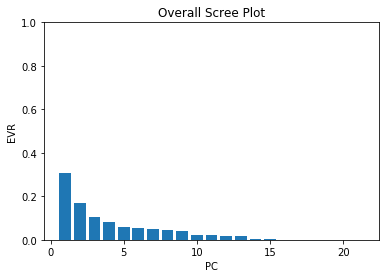

In [95]:
#scree plot
plt.bar(range(1,22),pca_test.explained_variance_ratio_)
plt.title('Overall Scree Plot')
plt.xlabel('PC')
plt.ylabel('EVR')
plt.ylim(0,1)

In [96]:
#implementing pca

pca = PCA(n_components=3)
X_scaled_pca = pca.fit_transform(X_scaled)

In [68]:
#kmeans testing K value


inertias_list = []
sil_list = []

for i in range(1,10):
    kmeans_1 = KMeans(n_clusters=i, random_state = 42)
    kmeans_1.fit(X_scaled_pca)
    inertias_list.append(kmeans_1.inertia_)
    try:
        sil_list.append(silhouette_score(X_scaled, kmeans_1.labels_))
    except ValueError:
        sil_list.append(np.nan)

Text(0.5, 1.0, 'Inertia plot')

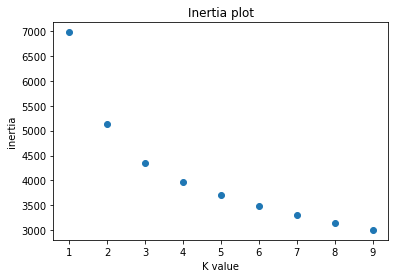

In [69]:
plt.scatter(range(1,10),inertias_list)
plt.xlabel('K value')
plt.ylabel('inertia')
plt.title('Inertia plot')

Text(0.5, 1.0, 'Silhouette plot')

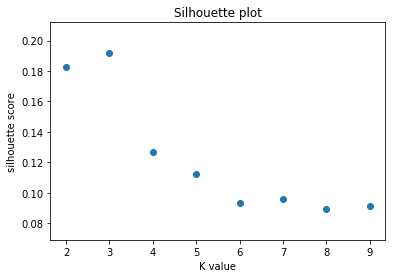

In [70]:
plt.scatter(range(1,10),sil_list)
plt.xlabel('K value')
plt.ylabel('silhouette score')
plt.title('Silhouette plot')

In [ ]:
# testing DBSCAN

metrics_range = ['euclidean', 'manhattan', 'cosine']
samples_range = range(1,10)
eps_range = np.arange(0.1,2,0.1)

sil2_list = []

for i in metrics_range:
    for j in samples_range:
        for k in eps_range:
            dbloop = DBSCAN(metric=i, min_samples=j, eps=k)
            dbloop.fit(X_scaled_pca)
            cluster_index_loop = np.where(dbloop.labels_ != -1)[0]
            try:
                sil2_list.append((i,j,k,silhouette_score(X_scaled[cluster_index_loop], dbloop.labels_[cluster_index_loop], metric = i)))
            except ValueError:
                sil2_list.append(np.nan)

In [ ]:
sil2_list

In [ ]:
scoredf = pd.DataFrame(sil2_list, columns = ['metric','min_samples','eps','score'])

In [ ]:
scoredf.sort_values(by='score', ascending = False).head(20)

In [70]:
#optimal DBSCAN model

dbscan_final = DBSCAN(metric='cosine', min_samples=9, eps=0.2)

# too many clusters?

In [92]:
# testing agglomerative clustering
# very long run time!

linkage_list = ['ward', 'complete', 'average','single']
clusters_range = range(1,10)

sil4_list = []

for i in linkage_list:
    for j in clusters_range:
        acloop = AgglomerativeClustering(linkage=i, n_clusters=j, distance_threshold=None)
        acloop.fit(X_scaled_pca)
        try:
            sil4_list.append((i,j,silhouette_score(X_scaled, acloop.labels_)))
        except ValueError:
            sil4_list.append(np.nan)

In [93]:
scoredf3 = pd.DataFrame(sil4_list[1:], columns = ['linkage','n_clusters','score'])
scoredf3.sort_values(by='score', ascending=False).head()

,linkage,n_clusters,score
18,average,2.0,0.272030
27,single,2.0,0.272030
33,single,8.0,0.270998
7,ward,9.0,0.269223
6,ward,8.0,0.268266


In [73]:
#optimal AC model

aggclus_final = AgglomerativeClustering(linkage = 'ward', n_clusters=9, distance_threshold=None)



In [74]:
#best overall model by teledf = dbscan

dbscan_final.fit(X_scaled_pca)

DBSCAN(algorithm='auto', eps=0.2, leaf_size=30, metric='cosine',
       metric_params=None, min_samples=9, n_jobs=None, p=None)

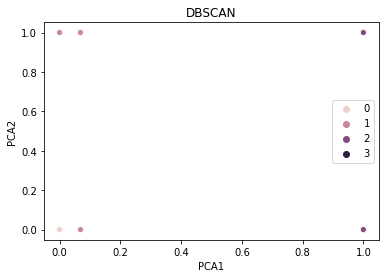

In [75]:
#visualization

sns.scatterplot(X_scaled[:,0],
               X_scaled[:,1],
               hue = dbscan_final.labels_)
plt.title('DBSCAN')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()

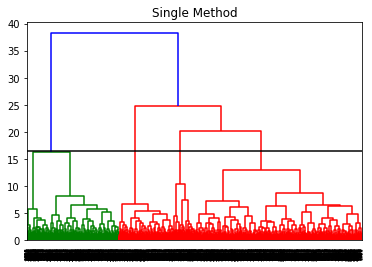

In [76]:
distances = linkage(X_scaled, method = 'ward')
dendrogram(distances)
plt.axhline (np.average(distances[-9:,2]),color = 'k')
plt.title(f'{i.capitalize()} Method')
plt.show()

In [77]:
for i,j,k in zip(linkage_list, label_list, sil_list):
    sns.scatterplot(X_scaled_pca[:,0],
                X_scaled_pca[:,1],
                hue = j)
        plt.title(f'Linkage = {i} \n Silhouette Score = {k:.3f}')
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.show()

IndentationError: unexpected indent (<ipython-input-77-1dcea27b44f4>, line 5)

In [ ]:
# try applying the binned labels to the original dataset
# put visuals that support your point into the appendix
# 

In [ ]:
X_plot = teledf_bins10.drop(columns='State')

scaler_plot = StandardScaler()
X_plot_scaled = scaler_plot.fit_transform(X_plot)

pca_plot = PCA()

X_plot_scaled_pca = pca_plot.fit_transform(X_plot_scaled)

In [ ]:
sns.scatterplot(X_plot_scaled_pca[:,0],
               X_plot_scaled_pca[:,1],
               hue = dbscan_final.labels_)
plt.title('DBSCAN')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()

In [ ]:
silhouette_score(X_scaled[cluster_index_loop], dbscan_final.labels_[cluster_index_loop])